In [6]:
# Import required libraries
import os

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE" #Corrects crashing issues in windows

import numpy as np
import matplotlib.pyplot as plt
import pymoo

# pymoo sub sections
# from pymoo.core.problem import Problem
from pymoo.core.problem import ElementwiseProblem
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.core.variable import Real, Integer, Choice, Binary
from pymoo.core.mixed import MixedVariableMating, MixedVariableGA, MixedVariableSampling, MixedVariableDuplicateElimination
from pymoo.optimize import minimize

# Utiliies for working with linkages (DeCoDE Lab)
from linkage_utils import *

# Other modules
import json
from IPython.display import HTML
import matplotlib.animation as animation
from tqdm.autonotebook import trange
import pickle

# Set random seed for consistency
np.random.seed(5)

In [7]:
# Manualy define the connectivity matrix
C = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

# List of fixed nodes
fixed_nodes = np.array([0,1])

# Initial positions
x0 = np.array([[0.4,0.5],
               [0.6,0.5],
               [0.4,0.6],
               [0.6,0.7],
               [0.5,0.75]])

# Motor
# Note: motor[0] is the driving node and motor[1] is being driven around Motor[0]
motor = np.array([0,2])

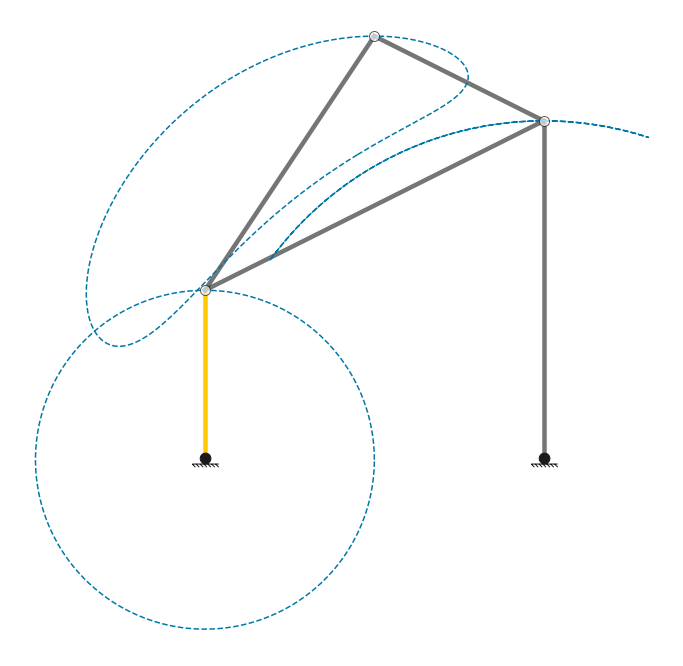

In [8]:
draw_mechanism(C,x0,fixed_nodes,motor)

In [9]:
# Initialize an empty list to store target curves
target_curves = []

# Loop to read 6 CSV files and store data in target_curves list
for i in range(6):
    # Load data from each CSV file and append it to the list
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

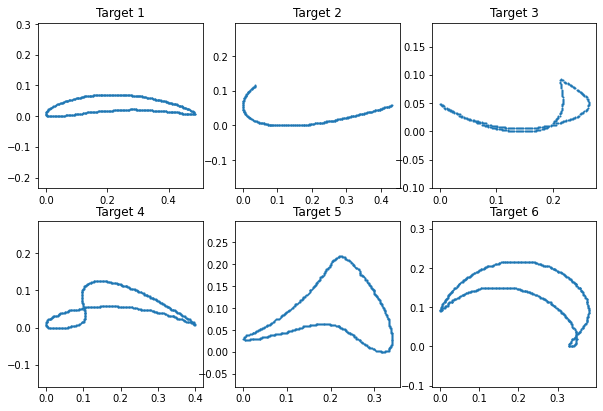

In [10]:
# # Plot all target curves

# Initialize a 2x3 subplot for plotting all target curves
fig, axs = plt.subplots(2, 3, figsize=(10, 6.7))

# Loop through the 6 target curves to plot them
for i in range(6):
    # Extract x and y coordinates from the target curve
    x_coords = np.array(target_curves[i])[:, 0]
    y_coords = np.array(target_curves[i])[:, 1]

    # Plot the curve on the respective subplot
    axs[i // 3, i % 3].scatter(x_coords, y_coords, s=1)

    # Set title for each subplot
    axs[i // 3, i % 3].set_title(f'Target {i + 1}')

    # Ensure equal scaling for x and y axes
    axs[i // 3, i % 3].axis('equal')


In [12]:
class mechanism_synthesis_optimization(ElementwiseProblem):

    # When intializing, set the mechanism size and target curve
    def __init__(self, target_point_cloud, N = 5):
        self.N = N
        variables = dict()

        # The upper triangular portion of our NxN Connectivity Matrix consists of Nx(N-1)/2 boolean variables:
        for i in range(N):
            for j in range(i):
                if i not in [0, 1, 2, 3, 4]:
                    variables["C" + str(j) + "_" + str(i)] = Binary()
        

#         # We Delete C0_1 since we know node 1 is connected to the motor
#         del variables["C0_1"]

        #Our position matrix consists of Nx2 real numbers (cartesian coordinate values) between 0 and 1
        for i in range(2*N):
            variables["X0" + str(i)] = Real(bounds=(0.0, 1.0))

        # Our node type vector consists of N boolean variables (fixed vs non-fixed)
#         for i in range(N):
#             variables["fixed_nodes" + str(i)] =  Binary(N)

        # Our target node is an integer between 1 and N-1, (any except the motor node).
        variables["target"] = Integer(bounds=(1,N-1))

        # Set up some variables in the problem class we inherit for pymoo
        # n_obj=number of objectives, n_constr=number of constraints
        # Our objectives are chamfer distance and material, and they both have constraints.
        super().__init__(vars=variables, n_obj=2, n_constr=2)

        # Store the target curve point cloud
        self.tpc = target_point_cloud


    def convert_1D_to_mech(self, x):
        N = self.N

        # Get target node value
        target = x["target"]

        # Build connectivity matrix from its flattened constitutive variables
        C_base = np.array([[0,0,1,0,0],
              [0,0,0,1,0],
              [1,0,0,1,1],
              [0,1,1,0,1],
              [0,0,1,1,0]])

        
        C = np.zeros((N,N))
#         x["C0_1"] = 1
        # Calculate the dimensions for placing C_base in the top left corner of C
        rows_base, cols_base = C_base.shape
        rows_c, cols_c = C.shape
        start_row = 0
        start_col = 0

        # Place C_base in the top left corner of C
        C[start_row:start_row + rows_base, start_col:start_col + cols_base] = C_base

        for i in range(N):
            for j in range(i):
                if i not in [0, 1, 2, 3, 4]:
                    C[i,j] = x["C" + str(j) + "_" + str(i)]
                    C[j,i] = x["C" + str(j) + "_" + str(i)]

        # Reshape flattened position matrix to its proper Nx2 shapevalid, CD, mat, CD_grad,mat_grad,g_c = functions_and_gradients(C,x0,fixed_nodes,target_pc, motor)
# x_history = []
# CD_history = []
# def callback(x):
#     x_history.append(x)
#     CD_history.append(CD(x))
# res = minimize(CD,x0.reshape(-1),jac=CD_grad,method='BFGS', callback = callback)
# ani = x_convergenceplot(x_history, range(len(x_history)))
# HTML(ani.to_html5_video())

        x0 = np.array([x["X0" + str(i)] for i in range(2*N)]).reshape([N,2])

        # Extract a list of Nodes that are fixed from boolean fixed_nodes vector
#         fixed_nodes = np.where(np.array([x["fixed_nodes" + str(i)] for i in range(N)]))[0].astype(int)
        fixed_nodes = np.array([0,1])

        #We fix the motor and original ground node as 0 and 1 respectively in this implementation
        motor=np.array([0,2])
        
#         print(C)
        
        return target, C, x0, fixed_nodes, motor



    def _evaluate(self, x, out, *args, **kwargs):
        #Convert to mechanism representation
        target, C, x0, fixed_nodes, motor = self.convert_1D_to_mech(x)

        #Call our evaluate function to get validity, CD, and material use
        valid, CD, mat, _ = evaluate_mechanism(C,x0,fixed_nodes, motor, self.tpc, idx=target, device='cpu',timesteps=2000)

        # check to see if the mechanism is valid
        if not valid:
            # if mechanism is invalid set the objective to infinity
            out["F"] = [np.Inf,np.Inf]
            out["G"] = [np.Inf, np.Inf]
        else:
            out["F"] = [CD,mat]

            # Set constraints as CD<=0.1 and Material<=10
            # Be careful about modifying these - designs that
            # violate the problem constraints will not be scored.
            out["G"] = [CD - 0.1, mat - 10]




Now let's try this with NSGA-II and one of the easier target curves. We will initialize with mechanisms with 5 nodes. You can test what happens if you increase this number. You should quickly discover that this naive parameterization does not perform well when initializing the GA with more complex mechanisms:

(-0.024300000000000002, 0.5103, -0.0035000000000000005, 0.07350000000000001)

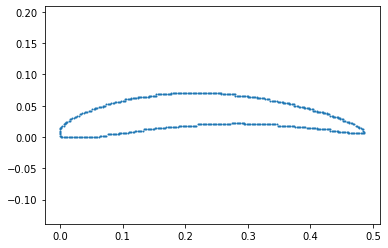

In [13]:
# Get target curve 0 and plot
target_index = 0
target_curve = np.array(target_curves[target_index])
plt.scatter(target_curve[:,0],target_curve[:,1],s=1)
plt.axis('equal')

In [16]:
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM

no_of_links = 5
population_size = 1000
generation = 100

# Initialize an empty list to store target curves
target_curves = []

# Loop to read 6 CSV files and store data in target_curves list
for i in range(6):
    # Load data from each CSV file and append it to the list
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))
    
# Setup Problem
problem = mechanism_synthesis_optimization(target_curve, no_of_links)


# # Set up GA with pop size of 100 -- see pymoo docs for more info on these settings!
# algorithm = NSGA2(pop_size=100, sampling=MixedVariableSampling(),
#                   mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
#                   eliminate_duplicates=MixedVariableDuplicateElimination())

# Set up GA with pop size of 100 -- see pymoo docs for more info on these settings!
algorithm = NSGA2(pop_size=population_size, sampling=MixedVariableSampling(),
                  mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                  eliminate_duplicates=MixedVariableDuplicateElimination(),)
#                   crossover=SBX(eta=40, prob=0.9),
#                   mutation=PM(eta=40))


# Run for 100 generations -- see pymoo docs for more info on these settings!
results = minimize(problem,
                   algorithm,
                   ('n_gen', generation),
                   verbose=True,
                   save_history=True,
                   seed=0)

n_gen  |  n_eval  | n_nds  |     cv_min    |     cv_avg    |      eps      |   indicator  
     1 |     1000 |      7 |  0.000000E+00 |           INF |             - |             -
     2 |     2000 |      3 |  0.000000E+00 |           INF |  0.5278079693 |         ideal
     3 |     3000 |      4 |  0.000000E+00 |           INF |  0.0081852566 |         ideal
     4 |     4000 |      4 |  0.000000E+00 |  0.1787454545 |  0.0584806012 |         ideal
     5 |     5000 |      5 |  0.000000E+00 |  0.1071699248 |  0.1517438294 |         ideal
     6 |     6000 |      9 |  0.000000E+00 |  0.0645555175 |  0.0646837848 |             f
     7 |     7000 |     11 |  0.000000E+00 |  0.0281752884 |  0.0216100581 |         ideal
     8 |     8000 |     11 |  0.000000E+00 |  0.0091395025 |  0.0355714150 |             f
     9 |     9000 |     10 |  0.000000E+00 |  0.0001896430 |  0.0634768370 |             f
    10 |    10000 |     10 |  0.000000E+00 |  0.000000E+00 |  0.0148353475 |             f

Pymoo automatically saves the optimal set of solutions and their corresponding performance. <code>results.X</code> will contain the solutions in 1D representation and <code>results.F</code> will contain the objectives. Note that if none of the solutions meet the constraints, the algorithm will not save anything on the best solutions). The constraints that we specify in the problem guidelines are used as a reference point for hypervolume calculations which we will use to measure your submissions performance.

Hyper Volume ~ 0.841546


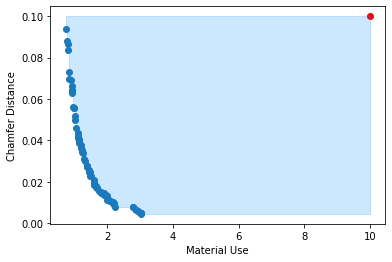

In [17]:
def plot_HV(F, ref):

    #Plot the designs
    plt.scatter(F[:,1],F[:,0])

    #plot the reference point
    plt.scatter(ref[1],ref[0],color="red")

    #plot labels
    plt.xlabel('Material Use')
    plt.ylabel('Chamfer Distance')

    #sort designs and append reference point
    sorted_performance = F[np.argsort(F[:,1])]
    sorted_performance = np.concatenate([sorted_performance,[ref]])

    #create "ghost points" for inner corners
    inner_corners = np.stack([sorted_performance[:,0], np.roll(sorted_performance[:,1], -1)]).T

    #Interleave designs and ghost points
    final = np.empty((sorted_performance.shape[0]*2, 2))
    final[::2,:] = sorted_performance
    final[1::2,:] = inner_corners

    #Create filled polygon
    plt.fill(final[:,1],final[:,0],color="#008cff",alpha=0.2)

if not results.X is None:
    #Specify reference point
    ref_point = np.array([0.1, 10])

    #Calculate Hypervolume
    ind = HV(ref_point)
    hypervolume = ind(results.F)

    #Print and plot
    print('Hyper Volume ~ %f' %(hypervolume))
    plot_HV(results.F, ref_point)
else:
    print('Did Not Find Solutions!!')

Now lets plot the results for the best chamfer distance solution

In [18]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,0])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

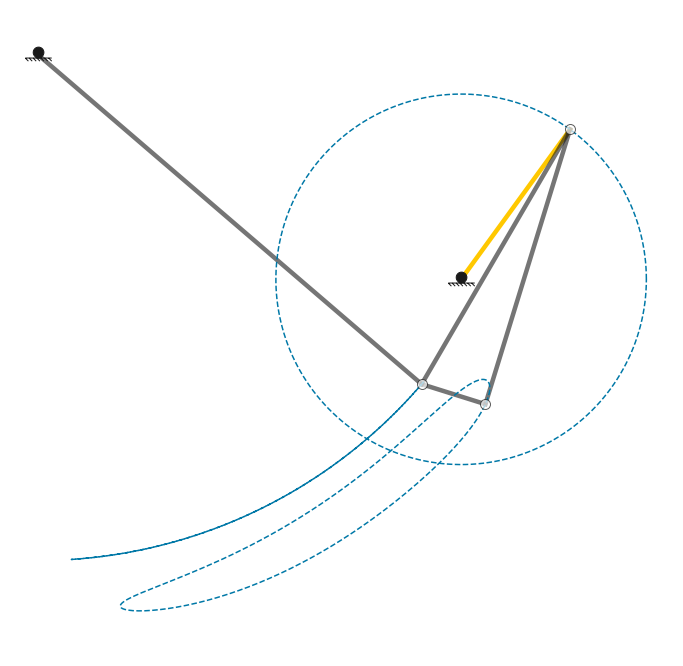

In [19]:
if not results.X is None:
    # Step 1: Reshape
    target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)
    # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)

else:
    print('Did Not Find Solutions!!')

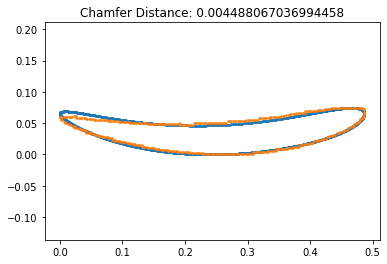

In [20]:
def comparecurves(C, x, fixed_nodes, motor, target, target_pc):
    valid, CD, mat, sol = evaluate_mechanism(C,x,fixed_nodes, motor, target_pc, idx=target,device='cpu',timesteps=2000)
    target_pc = get_oriented(target_pc)
    plt.scatter(sol[:,0],sol[:,1],s=2)
    plt.scatter(target_pc[:,0],target_pc[:,1],s=2)
    plt.title(f"Chamfer Distance: {CD}")
    plt.axis('equal')
if not results.X is None:
    comparecurves(C, x0, fixed_nodes, motor, target, target_curve)
else:
    print('Did Not Find Solutions!!')


Now lets see the solution with the least material use

In [21]:
if not results.X is None:
    if type(results.X)!=dict:
        best_sol = results.X[np.argmin(results.F[:,1])]
    else:
        best_sol = results.X
else:
    print('Did Not Find Solutions!!')

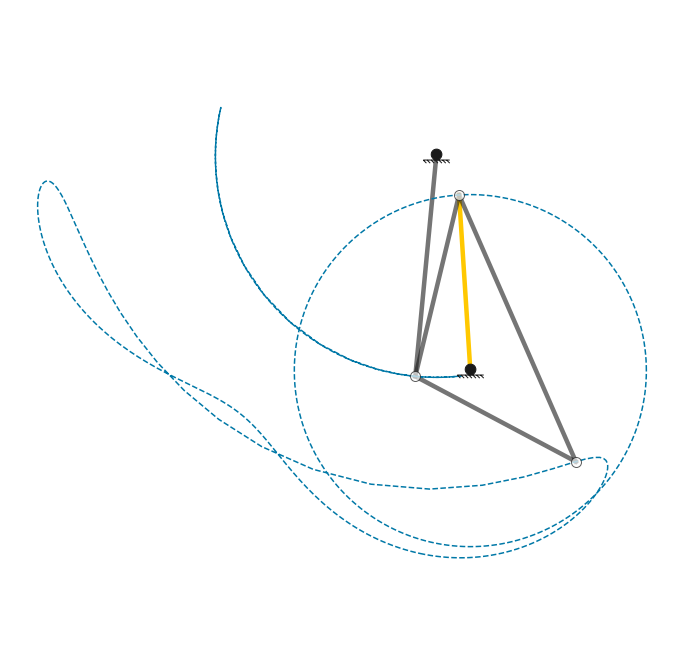

In [22]:
if not results.X is None:
    # Step 1: Reshape
    target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(best_sol)

    # Step 2: Draw
    draw_mechanism(C,x0,fixed_nodes,motor)
else:
    print('Did Not Find Solutions!!')

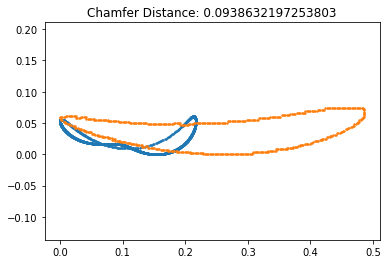

In [23]:
if not results.X is None:
    comparecurves(C, x0, fixed_nodes, motor, target, target_curve)
else:
    print('Did Not Find Solutions!!')

Now lets visualize the pareto front of the last generation

100%|██████████| 78/78 [00:07<00:00, 10.63it/s]


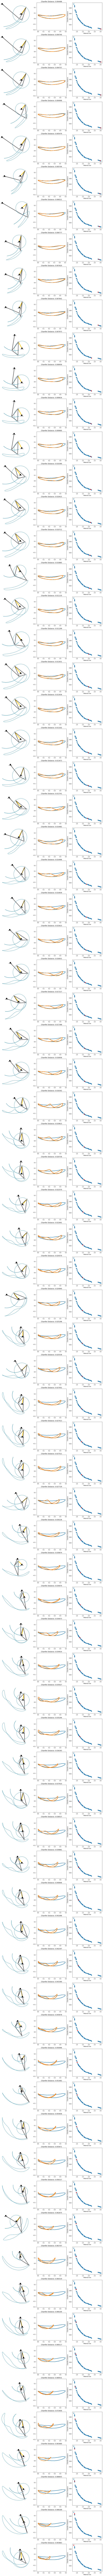

In [24]:
if not results.X is None:
    # first get generalized 1D representation
    mechanisms = []

    for x in results.pop.get("X"):
        target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
        mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))
    # Visualize Pareto Front
    visualize_pareto_front(np.array(mechanisms),results.pop.get("F"),target_curve)
else:
    print('Did Not Find Solutions!!')

### Now Let's Get a Submission Going

Now lets run the process for all the target curves in a loop:

Hyper Volume ~ 0.841546
Hyper Volume ~ 0.718158
Hyper Volume ~ 0.850725
Hyper Volume ~ 0.772960
Hyper Volume ~ 0.777963
Hyper Volume ~ 0.779023
--- Execution time: 17703.940754652023 seconds ---


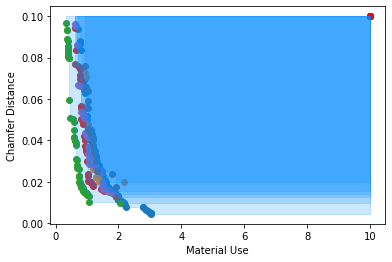

In [25]:
import time
start_time = time.time()

no_of_links = 5
population_size = 1000
generation = 100

# Initialize an empty list to store target curves
target_curves = []

# Loop to read 6 CSV files and store data in target_curves list
for i in range(6):
    # Load data from each CSV file and append it to the list
    target_curves.append(np.loadtxt('./data/%i.csv'%(i),delimiter=','))

for i,target_curve in enumerate(target_curves):
    # Setup Problem
    problem = mechanism_synthesis_optimization(target_curve,no_of_links)

    # Get Algorithm
    algorithm = NSGA2(pop_size=population_size, sampling=MixedVariableSampling(),
                      mating=MixedVariableMating(eliminate_duplicates=MixedVariableDuplicateElimination()),
                      eliminate_duplicates=MixedVariableDuplicateElimination(), verbose = True)

    results.X = None
    count=0
    while results.X is None and count!=3: #Total number of seeds to try

        # Run for 100 generations
        results = minimize(problem,
                           algorithm,
                           ('n_gen', generation),
                           verbose=True,
                           save_history=True,
                           seed=0+count,
                           display=best())
        if results.X is None:
            print('Did Not Find Solutions for Target ' + str(i) + '. Trying Seed ' + str(count+1+1) + '!')
            count+=1


    if results.X is None:
        print('Did Not Find Solutions for any Seed!!')
    else:
        mechanisms = []
        for x in results.X:
            target, C, x0, fixed_nodes, motor  = problem.convert_1D_to_mech(x)
            # target, C, x0, fixed_nodes, motor  = problem.fix_mechanism(target, C, x0, fixed_nodes, motor )
            mechanisms.append(to_final_representation(C,x0,fixed_nodes,motor,target))

        ref_point = np.array([0.1, 10])
        ind = HV(ref_point)
        hypervolume = ind(results.F)
        print('Hyper Volume ~ %f' %(hypervolume))
        plot_HV(results.F, ref_point)

        save_population_csv('./results/%i.csv'%i,mechanisms)
print("--- Execution time: %s seconds ---" % (time.time() - start_time))

Now let's see how we did:

In [26]:
evaluate_submission()

100%|██████████| 6/6 [00:14<00:00,  2.48s/it]

Score Break Down:
Curve 0: 0.841546
Curve 1: 0.718158
Curve 2: 0.850725
Curve 3: 0.772960
Curve 4: 0.777963
Curve 5: 0.779023
Overall Score: 0.790063


0.7900626325444224